In [13]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.metrics import r2_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, RocCurveDisplay
from sklearn.utils import compute_class_weight
from sklearn.decomposition import TruncatedSVD
from sklearn.cross_decomposition import PLSRegression
from tensorflow import keras
from tensorflow.keras.utils import plot_model
import tensorflow_model_optimization as tfmot
import tensorflow as tf
import joblib
import pathlib
import os
from data_parser import parse_json_data, process_path, parse_label

tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

In [14]:
#testdir
path = os.getcwd()
print("PATH: ", path)

PATH:  C:\Users\jesse\Desktop\files\summer\nirone-refactor\model\src


In [15]:
# Import dataset
all_features = []
all_labels = []
data_path = "../data/"

pes_features = []
wool_features = []
cotton_features = []

files = process_path(data_path)
for file_path in files:
    file_label = parse_label(file_path)
    file_features = parse_json_data(file_path)
    if (file_label == "pes"):
        pes_features.append(file_features)
    elif (file_label == "villa"):
        wool_features.append(file_features)
    elif (file_label == "puuvilla"):
        cotton_features.append(file_features)
    all_labels.append(file_label)
    all_features.append(file_features)

# Define test size and validation size split
test_size_split = 0.20

validation_size_split = 0.20

if len(pes_features) > len(cotton_features) & len(pes_features) > len(wool_features):
    max_size = len(pes_features)
elif len(cotton_features) > len(pes_features) & len(cotton_features) > len(wool_features):
    max_size = len(cotton_features)
else:
    max_size = len(wool_features)
print(f"Max Size for equal distribution {max_size}")
# Here we split dataset to equal distribution where rounded to nearest 10 scans / sample
# and where length of the training set can be divisible to nearest 10 scans for test split
feature_samples_count = max_size - (int)(max_size*validation_size_split)
print(feature_samples_count)
while feature_samples_count % 10 != 0:
    feature_samples_count -= 1

print("Nearest 10 scans count for all features after validation split")
print(feature_samples_count)

validation_samples_count = max_size - feature_samples_count
print(validation_samples_count)
while validation_samples_count % 10 != 0:
    validation_samples_count -= 1

print("Nearest 10 scans count for validation split")
print(validation_samples_count)

pes = pd.DataFrame(pes_features[:feature_samples_count])
cotton = pd.DataFrame(cotton_features[:feature_samples_count])
wool = pd.DataFrame(wool_features[:feature_samples_count])
# Combine features
all_eq_features = pd.concat([pes, cotton, wool], axis=0).reset_index(drop=True)

last = feature_samples_count + validation_samples_count
pes_val = pd.DataFrame(pes_features[feature_samples_count:last])
cotton_val = pd.DataFrame(cotton_features[feature_samples_count:last])
wool_val = pd.DataFrame(wool_features[feature_samples_count:last])
# Combine validation dataset
all_val_features = pd.concat([pes_val, cotton_val, wool_val], axis=0).reset_index(drop=True)

# One-hot encode labels dynamically
fabric_types = ["pes", "puuvilla", "villa"]
label_array = np.array([[1, 0, 0]] * feature_samples_count 
                       + [[0, 1, 0]] * feature_samples_count 
                       + [[0, 0, 1]] * feature_samples_count
                      )
labels_eq = pd.DataFrame(label_array, columns=fabric_types)

y_val_labels = np.array([[1, 0, 0]] * validation_samples_count 
                       + [[0, 1, 0]] * validation_samples_count
                       + [[0, 0, 1]] * validation_samples_count
                      )
val_labels_eq = pd.DataFrame(y_val_labels, columns=fabric_types)
val_labels_int = np.argmax(val_labels_eq, axis=1)

# Full dataset in dataframes
features = pd.DataFrame(all_features)
labels = pd.DataFrame(all_labels, columns=['fabric_type'])

Found 1430 .json files.
Max Size for equal distribution 399
320
Nearest 10 scans count for all features after validation split
320
79
Nearest 10 scans count for validation split
70


In [16]:
# Encode fabric_type labels with integers (Used to reverse labels back easily if needed)
label_encoder = LabelEncoder()
labels['fabric_type_encoded'] = label_encoder.fit_transform(labels['fabric_type'])

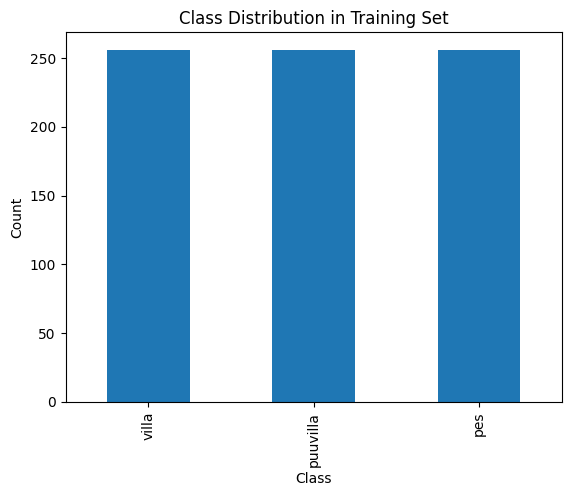

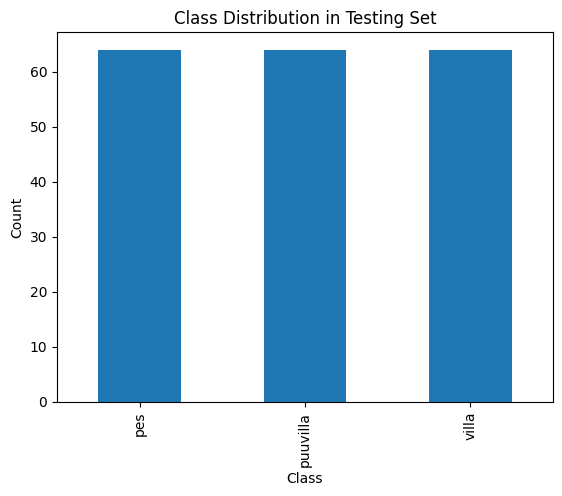

In [17]:
y_labels = labels_eq.idxmax(axis=1)

# Split data to train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    all_eq_features, 
    labels_eq, 
    test_size=test_size_split, 
    random_state=42,
    stratify=y_labels
)
y_train_int = np.argmax(y_train, axis=1)
y_test_int = np.argmax(y_test, axis=1)

def plot_class_distribution(y_data, label="Dataset"):
    class_counts = pd.Series(y_data).value_counts()
    class_counts.plot(kind='bar')
    plt.title(f"Class Distribution in {label}")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.show()

# Convert one-hot encoded labels back to categorical labels
y_train_labels = y_train.idxmax(axis=1)
y_test_labels = y_test.idxmax(axis=1)

# Plot for train and test sets
plot_class_distribution(y_train_labels, "Training Set")
plot_class_distribution(y_test_labels, "Testing Set")

In [18]:
# Define total epochs
total_epochs = 30

k = 6  # Number of SVD components to keep
n_pls = 3  # Number of PLS components

# Step 1: Fit SVD on the training set (Feature Reduction)
svd = TruncatedSVD(n_components=k)
X_train_svd = svd.fit_transform(X_train)  # Transform data
X_test_svd = svd.transform(X_test)

svd_matrix = svd.components_.T  # Transformation matrix

# Step 2: Fit PLS on the reduced SVD data
pls = PLSRegression(n_components=n_pls)
X_train_pls = pls.fit_transform(X_train_svd, y_train)  # Fit on SVD-transformed features
X_test_pls = pls.transform(X_test_svd)  # Apply transformation

pls_matrix = pls.x_weights_  # Extract PLS transformation matrix

class SVDLayer(tf.keras.layers.Layer):
    def __init__(self, svd_matrix, **kwargs):
        super(SVDLayer, self).__init__(**kwargs)
        self.svd_matrix = self.add_weight(
            name="svd_matrix", 
            shape=svd_matrix.shape, 
            initializer=tf.constant_initializer(svd_matrix), 
            trainable=False
        )

    def call(self, inputs):
        return tf.matmul(inputs, self.svd_matrix)  # Apply SVD transformation

class PLSLayer(tf.keras.layers.Layer):
    def __init__(self, pls_matrix, **kwargs):
        super(PLSLayer, self).__init__(**kwargs)
        self.pls_matrix = self.add_weight(
            name="pls_matrix", 
            shape=pls_matrix.shape, 
            initializer=tf.constant_initializer(pls_matrix), 
            trainable=False
        )

    def call(self, inputs):
        return tf.matmul(inputs, self.pls_matrix)  # Apply PLS transformation
# Build Model
model = keras.models.Sequential([
    SVDLayer(svd_matrix),
    PLSLayer(pls_matrix),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(3, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(
    X_train, 
    y_train_int,
    validation_data=(all_val_features, val_labels_int),
    epochs=total_epochs, 
)

model.evaluate(X_test, y_test_int, verbose=0)

model.summary()


Epoch 1/30

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.3259 - loss: 1.0958 - val_accuracy: 0.9857 - val_loss: 1.0172
Epoch 2/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.6404 - loss: 1.0053 - val_accuracy: 0.6810 - val_loss: 0.8289
Epoch 3/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.6723 - loss: 0.8033 - val_accuracy: 0.9524 - val_loss: 0.4541
Epoch 4/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.9533 - loss: 0.4122 - val_accuracy: 0.9714 - val_loss: 0.1552
Epoch 5/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.9700 - loss: 0.1883 - val_accuracy: 0.9952 - val_loss: 0.0553
Epoch 6/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9755 - loss: 0.1405 - val_accuracy: 0.9952 - val_loss: 0.0758
Epoch 7/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9591 - loss: 0.1274 - val_accuracy: 0.9952 - val_loss: 0.0423
Epoch 8/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9789 - loss: 0.0669 - val_accuracy: 0.9952 - 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ svd_layer (SVDLayer)                 │ (32, 6)                     │           3,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pls_layer (PLSLayer)                 │ (32, 3)                     │              18 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 512)                   │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 256)                   │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (32, 128)                   │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (32, 64)                    │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (32, 32)                    │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (32, 3)                     │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 533,213 (2.03 MB)

 Trainable params: 176,707 (690.26 KB)

 Non-trainable params: 3,090 (12.07 KB)

 Optimizer params: 353,416 (1.35 MB)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


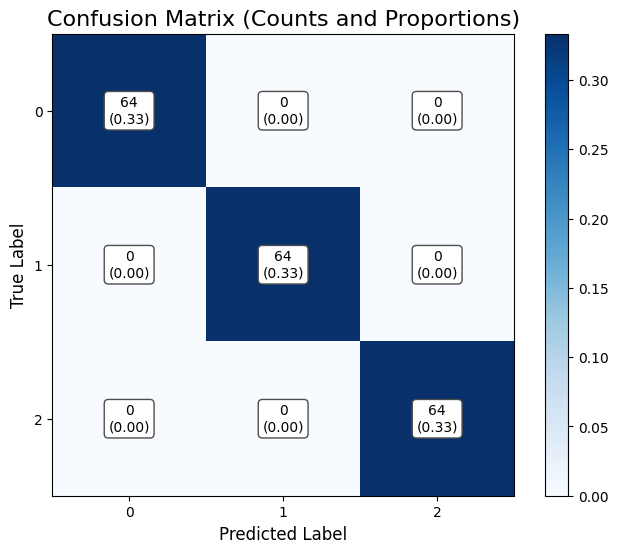

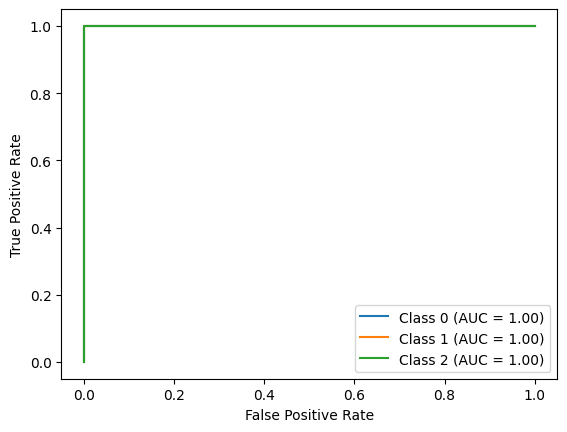

Metrics for Class 0:
Precision: 1.0
Recall: 1.0
F1-Score: 1.0


Metrics for Class 1:
Precision: 1.0
Recall: 1.0
F1-Score: 1.0


Metrics for Class 2:
Precision: 1.0
Recall: 1.0
F1-Score: 1.0




In [19]:
# Analytics, Visualization, e.g.

predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

# Confusion Matrix
raw_cm = confusion_matrix(y_test_int, predicted_labels)
normalized_cm = confusion_matrix(y_test_int, predicted_labels, normalize='all')

labels = []
for i in range(len(raw_cm)):
    for j in range(len(raw_cm)):
        labels.append(f"{raw_cm[i, j]} ({normalized_cm[i, j]:.2f})")
labels = np.array(labels).reshape(raw_cm.shape)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(normalized_cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()

# Adding annotations for raw counts and proportions
for i in range(len(raw_cm)):
    for j in range(len(raw_cm)):
        # Annotate raw count and normalized value
        text = f"{raw_cm[i, j]}\n({normalized_cm[i, j]:.2f})"
        plt.text(
            j, i, text,
            ha="center", va="center", fontsize=10,
            bbox=dict(boxstyle="round", facecolor='white', edgecolor='0.3')
        )

# Labels and title
plt.title("Confusion Matrix (Counts and Proportions)", fontsize=16)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.xticks(np.arange(len(raw_cm)), labels=np.arange(len(raw_cm)))
plt.yticks(np.arange(len(raw_cm)), labels=np.arange(len(raw_cm)))
plt.show()

# ROC
label_binarizer = LabelBinarizer()
y_onehot_test = label_binarizer.fit_transform(y_test_int)

for class_idx in range(len(label_binarizer.classes_)):
  fpr, tpr, thresholds = roc_curve(y_onehot_test[:, class_idx], predictions[:, class_idx])
  roc_auc = auc(fpr, tpr)
  display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                             estimator_name=f"Class {label_binarizer.classes_[class_idx]}")
  display.plot(ax=plt.gca())
plt.show()

# Metrics
for i in range(len(raw_cm)):
    precision = precision_score(y_test_int == i, predicted_labels == i)
    recall = recall_score(y_test_int == i, predicted_labels == i)
    f1 = f1_score(y_test_int == i, predicted_labels == i)
    print(f"Metrics for Class {i}:")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")
    print("\n")



In [20]:
# Usage example:
# Requires validation folder to have samples
def predict_textile(feature_list: list[float]):
    features = np.expand_dims(feature_list, axis=0)
    predictions = model.predict(features, verbose=0)
    flattened = np.argmax(predictions, axis=1)
    fabric_types = label_encoder.inverse_transform(flattened)
    return predictions, fabric_types

def run_validations():
    # Import dataset
    all_features = []
    all_labels = []
    data_path = "../data/"
    files = process_path(data_path)
    for file_path in files:
        file_label = parse_label(file_path)
        file_features = parse_json_data(file_path)
        all_labels.append(file_label)
        all_features.append(file_features)

    num_vals = len(all_features)
    i = 0
    pes_incorrect = 0
    cotton_incorrect = 0
    wool_incorrect = 0
    while i < num_vals-1:
        predictions, fabric_types = predict_textile(all_features[i])
        print(f"Validating {all_labels[i]} - Out: {fabric_types[0]}\n")
        if not all_labels[i] == fabric_types[0]:
            if all_labels[i] == "pes":
                pes_incorrect += 1
            elif all_labels[i] == "puuvilla":
                cotton_incorrect += 1
            elif all_labels[i] == "villa":
                wool_incorrect += 1
        i += 1

    print(f"Results:\n Pes Incorrect: {pes_incorrect}\n Cotton Incorrect: {cotton_incorrect}\n Wool Incorrect: {wool_incorrect}")
    return

run_validations()

Found 1430 .json files.
Validating pes - Out: pes

Validating pes - Out: pes

Validating pes - Out: pes

Validating pes - Out: pes

Validating pes - Out: pes

Validating pes - Out: pes

Validating pes - Out: pes

Validating pes - Out: pes

Validating pes - Out: pes

Validating pes - Out: pes

Validating pes - Out: pes

Validating pes - Out: pes

Validating pes - Out: pes

Validating pes - Out: pes

Validating pes - Out: pes

Validating pes - Out: pes

Validating pes - Out: pes

Validating pes - Out: pes

Validating pes - Out: pes

Validating pes - Out: pes

Validating pes - Out: pes

Validating pes - Out: pes

Validating pes - Out: pes

Validating pes - Out: pes

Validating pes - Out: pes

Validating pes - Out: pes

Validating pes - Out: pes

Validating pes - Out: pes

Validating pes - Out: pes

Validating pes - Out: pes

Validating pes - Out: pes

Validating pes - Out: pes

Validating pes - Out: pes

Validating pes - Out: pes

Validating pes - Out: pes

Validating pes - Out: pes

Vali